Target:

1. Use LR scheduler
2. Experiment with a higher learning rate along with LR scheduler to fasten up convergence

Results:

1. Parameters: 7924
2. Best Training Accuracy: 99.12
3. Best Test Accuracy: 99.42 (14th Epoch)

Analysis:

1. Model seems to perform well consistently during the final epochs.
2. Finding a good LR schedule is hard, We have tried to make it learn faster and effectively by reducing LR after 10th epoch.
3. We did achieve our target of 99.4 % accuracy, but an accuracy of 99.5 % is still achievable with an even better training. 

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


In [3]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomRotation((-10., 10.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [4]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [5]:
torch.manual_seed(1)
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)

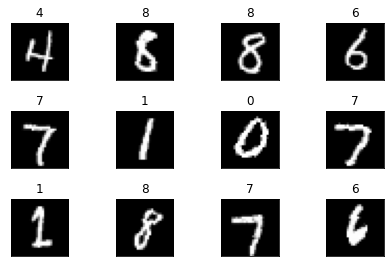

In [6]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader)) 

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

In [27]:
drop = 0.02
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    # ---------Input BLOCK 2---------

    # Input size = 28
    self.convblock1 = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(3, 3), padding=0, bias=False),
      nn.ReLU(),
      nn.BatchNorm2d(4),
      nn.Dropout(drop)
    ) # output_size = 26  RF = 3

    # -------------------------------
    
    # ------CONVOLUTION BLOCK 1------

    self.convblock2 = nn.Sequential(
      nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
      nn.ReLU(),
      nn.BatchNorm2d(8),
      nn.Dropout(drop)
    ) # output_size = 24  RF = 5

    self.convblock3 = nn.Sequential(
      nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
      nn.ReLU(),
      nn.BatchNorm2d(16),
      nn.Dropout(drop)
    ) # output_size = 22  RF = 7

    self.convblock4 = nn.Sequential(
      nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
      nn.ReLU(),
      nn.BatchNorm2d(16),
      nn.Dropout(drop)
    ) # output_size = 20  RF = 9

    # -------------------------------
    
    # -------TRANSITION BLOCK 1------

    self.pool1 = nn.MaxPool2d(2, 2) # output_size = 10   RF = 10
    
    self.convblock5 = nn.Sequential(
      nn.Conv2d(in_channels=16, out_channels=4, kernel_size=(1, 1), padding=0, bias=False),
      nn.ReLU(),
      nn.BatchNorm2d(4),
      nn.Dropout(drop)
    ) # output_size = 10  RF = 10

    # -------------------------------
    
    # ------CONVOLUTION BLOCK 2------

    self.convblock6 = nn.Sequential(
      nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
      nn.ReLU(),
      nn.BatchNorm2d(8),
      nn.Dropout(drop)
    ) # output_size = 8  RF = 14

    self.convblock7 = nn.Sequential(
      nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
      nn.ReLU(),
      nn.BatchNorm2d(16),
      nn.Dropout(drop)
    ) # output_size = 6  RF = 18

    self.convblock8 = nn.Sequential(
      nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
      nn.ReLU(),
      nn.BatchNorm2d(16),
      nn.Dropout(drop)
    ) # output_size = 4  RF = 22

    # -------------------------------

    # ---------OUTPUT BLOCK----------
    
    self.gap = nn.Sequential(
      nn.AvgPool2d(kernel_size=4)
    ) # output_size = 1 RF = 28

    self.convblock9 = nn.Sequential(
      nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
    ) # output_size = 1  RF = 28

    # -------------------------------
    
  def forward(self, x):
    x = self.convblock1(x)
    
    x = self.convblock2(x)
    x = self.convblock3(x)
    x = self.convblock4(x)

    x = self.pool1(x)
    x = self.convblock5(x)

    x = self.convblock6(x)
    x = self.convblock7(x)
    x = self.convblock8(x)

    x = self.gap(x)
    x = self.convblock9(x)

    x = x.view(-1, 10)
    return F.log_softmax(x, dim=-1)
     

In [28]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              36
              ReLU-2            [-1, 4, 26, 26]               0
       BatchNorm2d-3            [-1, 4, 26, 26]               8
           Dropout-4            [-1, 4, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             288
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,152
             ReLU-10           [-1, 16, 22, 22]               0
      BatchNorm2d-11           [-1, 16, 22, 22]              32
          Dropout-12           [-1, 16, 22, 22]               0
    

In [29]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [30]:
def FillWrongPredictions (data, target, pred, out_dict):
  pred = pred.argmax(dim=1)
  correct_pred_indices = pred.eq(target) # list of Trues and Falses, Trues being at indices of correct predictions
  data = data.tolist()
  target = target.tolist()
  pred = pred.tolist()
  out_dict['images'] += [data[x] for x in range(len(correct_pred_indices)) if not correct_pred_indices[x]]
  out_dict['ground_truths'] += [target[x] for x in range(len(correct_pred_indices)) if not correct_pred_indices[x]]
  out_dict['predicted_vals'] += [pred[x] for x in range(len(correct_pred_indices)) if not correct_pred_indices[x]]

def DisplayWrongPredictions (data_dict):
  fig = plt.figure(figsize=(20, 20))

  for i in range(len(data_dict['images'])):
    plt.subplot(10,len(data_dict['images'])/10 + 1, i+1)
    plt.imshow(data_dict['images'][i][0], cmap='gray_r')
    plt.title(f"GT: {data_dict['ground_truths'][i]}, P: {data_dict['predicted_vals'][i]}")
    plt.xticks([])
    plt.yticks([])

In [31]:
from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def Train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def Test(model, device, test_loader, fill_incorrect_samples):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)

            if fill_incorrect_samples:
              FillWrongPredictions (data, target, output, test_incorrect_pred)

    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [32]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  Train(model, device, train_loader, optimizer)
  Test(model, device, test_loader, epoch == num_epochs)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 1


Train: Loss=0.1088 Batch_id=117 Accuracy=87.25: 100%|██████████| 118/118 [00:18<00:00,  6.28it/s]


Test set: Average loss: 0.0849, Accuracy: 9730/10000 (97.30%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 2


Train: Loss=0.0569 Batch_id=117 Accuracy=97.48: 100%|██████████| 118/118 [00:15<00:00,  7.52it/s]


Test set: Average loss: 0.0487, Accuracy: 9843/10000 (98.43%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 3


Train: Loss=0.0722 Batch_id=117 Accuracy=97.99: 100%|██████████| 118/118 [00:14<00:00,  8.40it/s]


Test set: Average loss: 0.0380, Accuracy: 9874/10000 (98.74%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 4


Train: Loss=0.0695 Batch_id=117 Accuracy=98.19: 100%|██████████| 118/118 [00:14<00:00,  8.32it/s]


Test set: Average loss: 0.0355, Accuracy: 9894/10000 (98.94%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 5


Train: Loss=0.1745 Batch_id=117 Accuracy=98.34: 100%|██████████| 118/118 [00:14<00:00,  8.26it/s]


Test set: Average loss: 0.0352, Accuracy: 9888/10000 (98.88%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 6


Train: Loss=0.0139 Batch_id=117 Accuracy=98.43: 100%|██████████| 118/118 [00:14<00:00,  8.26it/s]


Test set: Average loss: 0.0324, Accuracy: 9899/10000 (98.99%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 7


Train: Loss=0.0411 Batch_id=117 Accuracy=98.66: 100%|██████████| 118/118 [00:15<00:00,  7.80it/s]


Test set: Average loss: 0.0335, Accuracy: 9897/10000 (98.97%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 8


Train: Loss=0.0575 Batch_id=117 Accuracy=98.63: 100%|██████████| 118/118 [00:14<00:00,  8.38it/s]


Test set: Average loss: 0.0258, Accuracy: 9914/10000 (99.14%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 9


Train: Loss=0.0366 Batch_id=117 Accuracy=98.69: 100%|██████████| 118/118 [00:13<00:00,  8.44it/s]


Test set: Average loss: 0.0296, Accuracy: 9917/10000 (99.17%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 10


Train: Loss=0.0240 Batch_id=117 Accuracy=98.79: 100%|██████████| 118/118 [00:14<00:00,  8.28it/s]


Test set: Average loss: 0.0293, Accuracy: 9907/10000 (99.07%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0081 Batch_id=117 Accuracy=98.94: 100%|██████████| 118/118 [00:13<00:00,  8.43it/s]


Test set: Average loss: 0.0205, Accuracy: 9934/10000 (99.34%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0064 Batch_id=117 Accuracy=99.09: 100%|██████████| 118/118 [00:15<00:00,  7.79it/s]


Test set: Average loss: 0.0194, Accuracy: 9936/10000 (99.36%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0468 Batch_id=117 Accuracy=99.12: 100%|██████████| 118/118 [00:13<00:00,  8.44it/s]


Test set: Average loss: 0.0196, Accuracy: 9937/10000 (99.37%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0471 Batch_id=117 Accuracy=99.10: 100%|██████████| 118/118 [00:14<00:00,  8.31it/s]


Test set: Average loss: 0.0191, Accuracy: 9942/10000 (99.42%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0357 Batch_id=117 Accuracy=99.11: 100%|██████████| 118/118 [00:14<00:00,  8.13it/s]


Test set: Average loss: 0.0191, Accuracy: 9941/10000 (99.41%)

Adjusting learning rate of group 0 to 1.0000e-02.


Text(0.5, 1.0, 'Test Accuracy')

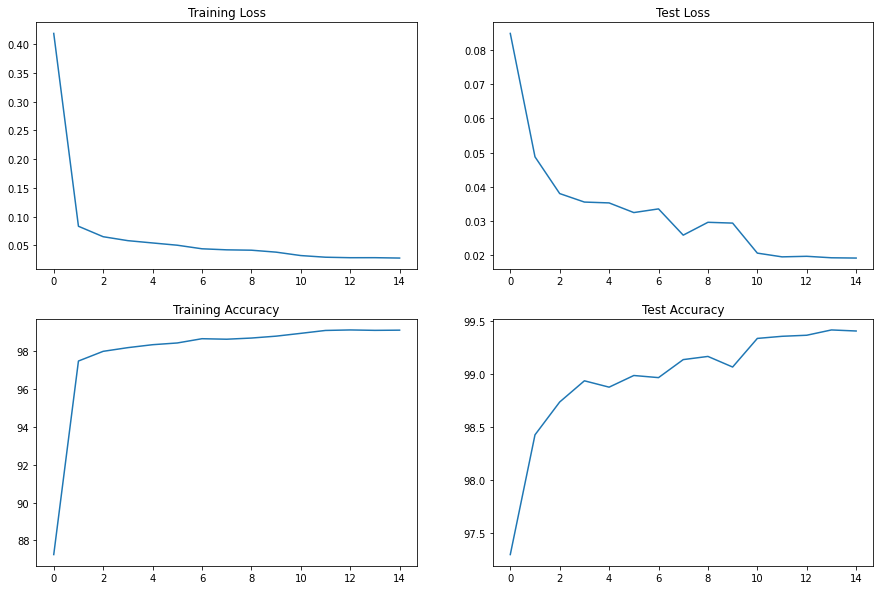

In [33]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

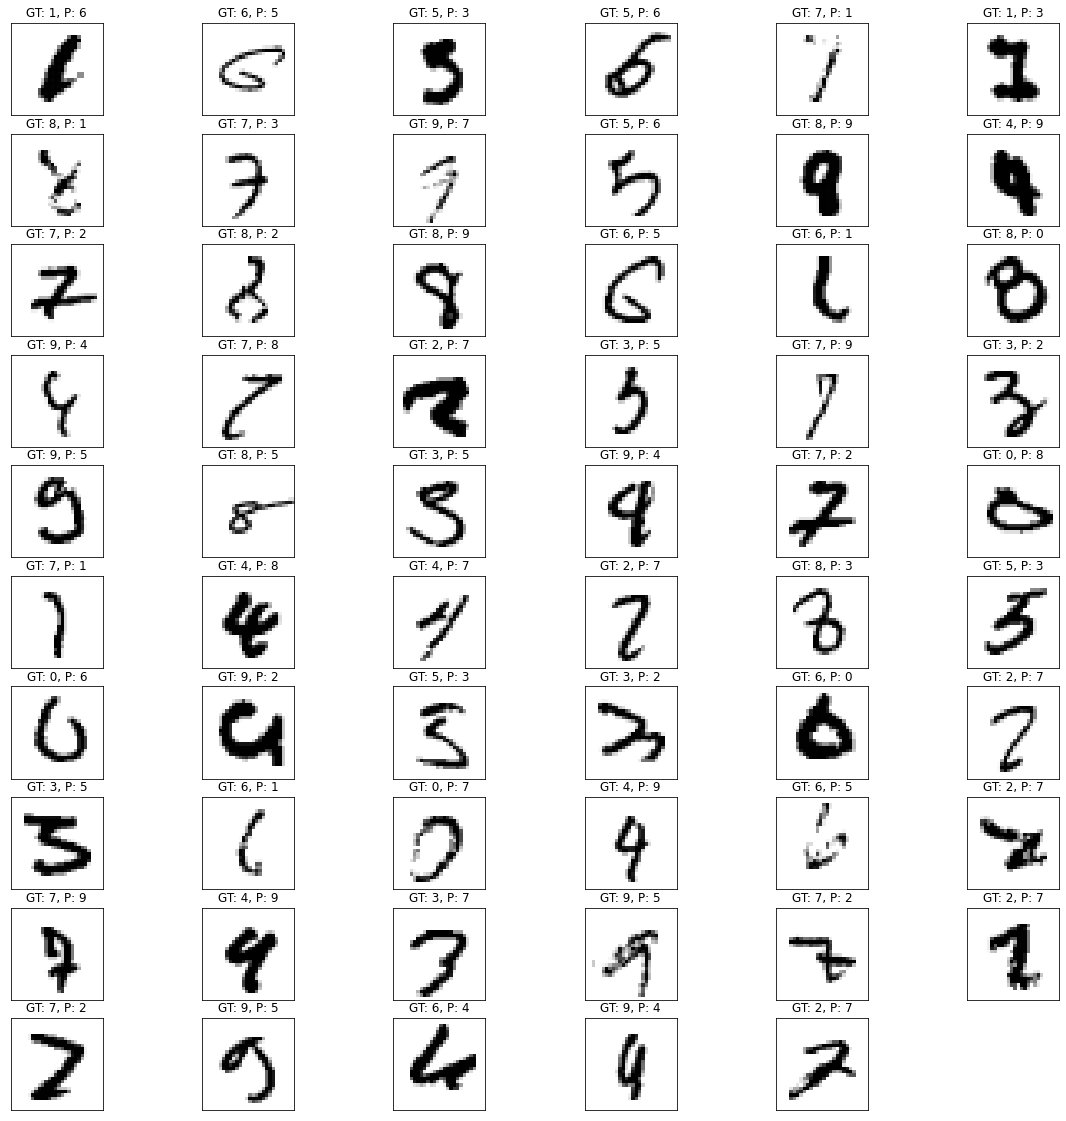

In [34]:
# From test set
DisplayWrongPredictions (test_incorrect_pred)